In [ ]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
fraud_folder = '/content/drive/MyDrive/fraud/fraud data'
not_fraud_folder = '/content/drive/MyDrive/fraud/Not fraud'

In [ ]:
IMG_SIZE = (96, 96)

In [ ]:
def load_images(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, IMG_SIZE)
        img = img.astype('float32') / 255.0
        images.append(img)
        labels.append(label)
    return images, labels

In [ ]:
fraud_images, fraud_labels = load_images(fraud_folder, 1)
not_fraud_images, not_fraud_labels = load_images(not_fraud_folder, 0)

In [ ]:
X = np.array(fraud_images + not_fraud_images)
y = np.array(fraud_labels + not_fraud_labels)

In [ ]:
X = X.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")

Training set: 88 images
Validation set: 23 images


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False

model = Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
    tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=100,
    validation_data=val_datagen.flow(X_val, y_val),
    steps_per_epoch=len(X_train) // 16,
    validation_steps=len(X_val) // 16
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.4919 - loss: 0.7367

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 603ms/step - accuracy: 0.4997 - loss: 0.7378 - val_accuracy: 0.6522 - val_loss: 0.6139
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.7636 - loss: 0.5792 - val_accuracy: 0.7826 - val_loss: 0.5049
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.7463 - loss: 0.4381 - val_accuracy: 0.7391 - val_loss: 0.5226
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.8278 - loss: 0.3810 - val_accuracy: 0.8261 - val_loss: 0.5330
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.8890 - loss: 0.3367 - val_accuracy: 0.8261 - val_loss: 0.5542
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.8750 - loss: 0.2762 - val_accuracy: 0.8261 - val_loss: 0.4947
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.8869 - loss: 0.2990 - val_accuracy: 0.6957 - val_loss: 0.5207
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - accuracy: 0.8818 - loss: 0.2601 - val_accuracy: 0.8696 - val_loss: 0.

Training plots saved to training_plots.png


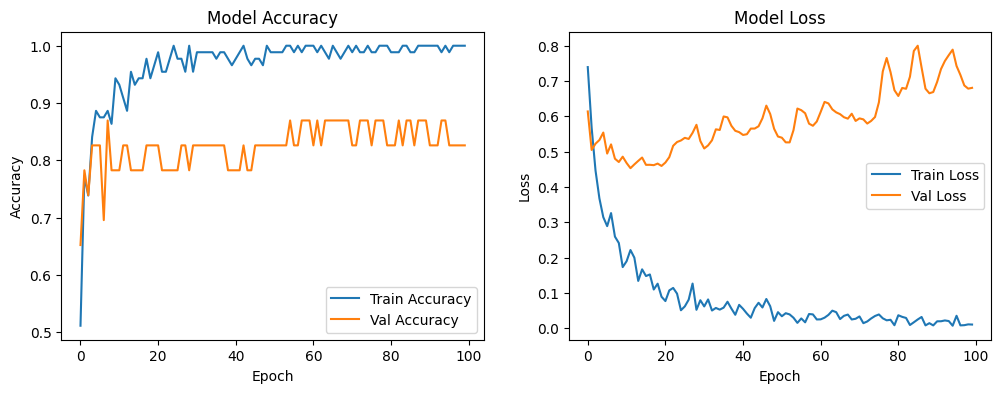

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_plots.png')
print("Training plots saved to training_plots.png")

In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8261 - loss: 0.6807
Validation Loss: 0.6807
Validation Accuracy: 0.8261


In [ ]:
def predict_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype('float32') / 255.0
    img = img.reshape(1, IMG_SIZE[0], IMG_SIZE[1], 1)
    prediction = model.predict(img)[0][0]
    label = "Fraud" if prediction >= 0.5 else "Not Fraud"
    confidence = prediction if prediction >= 0.5 else 1 - prediction
    return label, confidence

fraud_img_path = '/content/540.png'
label, confidence = predict_image(fraud_img_path)
print(f"Fraud Image Prediction: {label} (Confidence: {confidence:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Fraud Image Prediction: Fraud (Confidence: 0.66)


In [ ]:
not_fraud_img_path = '/content/581.png'
label, confidence = predict_image(not_fraud_img_path)
print(f"Not Fraud Image Prediction: {label} (Confidence: {confidence:.2f})")